## SI507 Final Project: Sentiment Analysis on Subreddit r/Obesity Comments

#### Approximate Difficulty
- Web API you haven’t used before that requires OAuth: 6
    - https://www.reddit.com/dev/api/
- Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System Data: 2
    - [Data Page](https://catalog.data.gov/dataset/nutrition-physical-activity-and-obesity-behavioral-risk-factor-surveillance-system)

- Sentiment analysis --> feed data from tree directly to perform analyses
- Networkx => save trees in form of .json data
- [PRAW 7.7.1 Documentation](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html)
- [Working with Reddit Comment Trees](https://www.reddit.com/r/datasets/s/c34hswA2td)
- [Creating Reply Networks from Reddit Comment Threads](https://jrashford.com/2022/01/21/creating-reply-networks-from-reddit-comment-threads/)

In [1]:
# imports
import praw
import networkx as nx
import matplotlib.pyplot as plt
import json
import textwrap
from datetime import datetime

# go to reddit.com/prefs/apps to edit app information
# client_id: freedom_or_chemicals
# sec_key: SuhVQ8O5zPcQ9qw0BSwGsi5pQn_aBQ
# user_agent/APP Name: VnWlWdqCq0If8VbJAqJRzw

In [215]:
# Initialize the Reddit instance with OAuth2 credentials to access Reddit API

reddit = praw.Reddit(
    client_id="VnWlWdqCq0If8VbJAqJRzw",
    client_secret="SuhVQ8O5zPcQ9qw0BSwGsi5pQn_aBQ",
    user_agent="script for obesity research 1.0",
)

### Scrape Data via Reddit API (don't need to run if JSON files exist)

In [216]:
# Fetch the top n posts from a given subreddit

# top_comment_list = []

# # define target subreddit for scraping
# subreddit = reddit.subreddit("Obesity")

# for submission in subreddit.top(limit=100):
#     # append submission info into list
#     submission_info = {"submission_id": submission.id, "title": submission.title}
#     top_comment_list.append(submission_info)

#     # retrieve any comments that may be collapsed
#     submission.comments.replace_more(limit=None)

#     # append comments to list that will be nested
#     comments_for_submission = []
#     for comment in submission.comments.list():
#         # only comment body
#         # other options
#         # .author
#         # .score - upvotes or downvotes
#         # .parent_id
#         comment_info = {
#             "body": comment.body,
#             "timestamp": comment.created_utc,
#             "parent": comment.parent_id,
#             "comment_id": comment.id
#         }
#         comments_for_submission.append(comment_info)
#     # update last position of the list with nested information
#     top_comment_list[-1]["comments"] = comments_for_submission

# # save scraped contents in json file
# with open("top_comment_data.json", "w") as json_file:
#     json.dump(top_comment_list, json_file, indent=2)

*It seems that there are API call limitations, so set the post limit to 100 for now.*

In [217]:
# # Now fetch the newest n posts from a given subreddit
# newest_comment_list = []

# # define target subreddit for scraping
# subreddit = reddit.subreddit("Obesity")

# for submission in subreddit.new(limit=100):
#     # append submission info into list
#     submission_info = {"submission_id": submission.id, "title": submission.title}
#     newest_comment_list.append(submission_info)

#     # retrieve any comments that may be collapsed
#     submission.comments.replace_more(limit=None)

#     # append comments to list that will be nested
#     comments_for_submission = []
#     for comment in submission.comments.list():
#         # only comment body
#         # other options
#         # .author
#         # .score - upvotes or downvotes
#         # .parent_id
#         comment_info = {
#             "body": comment.body,
#             "timestamp": comment.created_utc,
#             "parent": comment.parent_id,
#         }
#         comments_for_submission.append(comment_info)
#     # update list item with nested information
#     newest_comment_list[-1]["comments"] = comments_for_submission

# # save scraped contents in json file
# with open("new_comment_data.json", "w") as json_file:
#     json.dump(newest_comment_list, json_file, indent=2)

### Create Trees from JSON Data for Each Post

In [26]:
# DON'T TOUCH FOR NOW
def buildCommentHierarchy(submission):
    '''takes the data of a single reddit post and formats it so it can be parsed and plotted.
       This is done by checking the parent ID and comment ID of each comment (or lack thereof).
    '''
    submission_id = submission["submission_id"]
    title = submission["title"]
    comments = submission["comments"]

    # create a dictionary to store comments by their IDs
    comment_dict = {comment["comment_id"]: comment for comment in comments}

    # create a dictionary to store hierarchies (for top-level comments)
    hierarchy = {"submission_id": submission_id, "title": title, "comments": {}}

    # # Iterate over comments to build the hierarchy
    # for comment in comments:
    #     comment_id = comment["comment_id"]
    #     parent_id = comment.get("parent", None)

    #     # If the comment has no parent or its parent is the post itself, it's a top-level comment
    #     if parent_id is None or parent_id == "t3_" + submission_id:
    #         hierarchy["comments"][comment_id] = {"data": comment, "replies": {}}
    #     else:
    #         # If the parent is already in the hierarchy, add the comment as a reply
    #         if parent_id in hierarchy["comments"]:
    #             parent_comment = hierarchy["comments"][parent_id]
    #             # Check if 'replies' key exists, if not, create it
    #             if "replies" not in parent_comment:
    #                 parent_comment["replies"] = {}
    #             parent_comment["replies"][comment_id] = {"data": comment, "replies": {}}
    #         else:
    #             # If the parent is not in the hierarchy, add both parent and comment
    #             parent_id_without_prefix = parent_id.replace("t1_", "")
    #             parent_comment = comment_dict.get(parent_id_without_prefix, None)
    #             if parent_comment is not None:
    #                 hierarchy["comments"][parent_id_without_prefix] = {
    #                     "data": parent_comment,
    #                     "replies": {comment_id: {"data": comment, "replies": {}}},
    #                 }

    return hierarchy

In [ ]:
def makehiearchy(data):
    result = []
    d = { "0": { "children": result } }
    for id, name, child_id in zip(data["id"], data["name"], data["child_id"]):
        d[id] = { "name": name, "id": id, "child_id": child_id }
    
    for id, child_id in zip(data["id"], data["child_id"]):
        parent = d[child_id]
        if "children" not in parent:
            parent["children"] = []
        parent["children"].append(d[id])

    return result

# Example run
data = {
    'id': ['2', '13', '14', '15', '16', '17', '18'],
    'name': ['color', 'red', 'blue', 'ruby red', 'mobile', 'iphone', 'sumsung'],
    'child_id': ['0', '2', '2', '13', '0', '16', '16']
}
hierarchy = makehiearchy(data)

In [27]:
hierarchy

[{'name': 'color',
  'id': '2',
  'child_id': '0',
  'children': [{'name': 'red',
    'id': '13',
    'child_id': '2',
    'children': [{'name': 'ruby red', 'id': '15', 'child_id': '13'}]},
   {'name': 'blue', 'id': '14', 'child_id': '2'}]},
 {'name': 'mobile',
  'id': '16',
  'child_id': '0',
  'children': [{'name': 'iphone', 'id': '17', 'child_id': '16'},
   {'name': 'sumsung', 'id': '18', 'child_id': '16'}]}]

In [ ]:
def isTopComment(comment):
    '''Returns True if the comment is a top level comment and False if not
    Parameters
    -------------------
    comment: dictionary
        key-value pairs with the information of a comment
    Returns
    -------------------
    bool
        returns True if the prefix of a comment's parent ID is t3_, and returns False if otherwise
    '''
    if comment['parent'][:3] == 't3_':
        return True
    else:
        return False

In [ ]:
def build_comment_tree(comments):
    tree = []
    di = {"0": { "comment": tree } }
    # create a dictionary with key-value pairs using the unique comment IDs as keys
    for comment in comments:
        di[comment['comment_id']] = comment
    for comment_id, parent_id in comment["comment_id"], comment["parent_id"]:
        parent = di[parent_id]
        if "comment" not in parent:
            parent["children"] = []
        parent["children"].append(d[id])
    
                

In [17]:
# Load JSON data from file
with open("json_data/top_comment_data.json", "r") as file:
    data = json.load(file)

In [18]:
data[0]['comments']

[{'body': 'From the conclusion portion:\n\n"....weight loss is associated with higher mortality rates only if it is unintentional."',
  'timestamp': 1649303344.0,
  'parent': 't3_pvwutv',
  'comment_id': 'i3pxtag'},
 {'body': 'No shit.',
  'timestamp': 1656525086.0,
  'parent': 't3_pvwutv',
  'comment_id': 'ie7ompr'},
 {'body': 'After I lost 80 lbs a nurse told me it’s good to keep fat on there in case you suffer a disease and can’t eat you have extra energy to burn. \n\nI guess that’s some sound logic, but no medical professional who didn’t also have a weight problem told me it’s better to be a little chubby than to have the chiseled ten pack that I achieved. \n\nAdditionally, it’s more dangerous for men to sustain extra adipose tissue than it is for women, because of the way it accumulates around men’s midsections rather than distributing nicely everywhere.',
  'timestamp': 1688244646.0,
  'parent': 't3_pvwutv',
  'comment_id': 'jqaybnk'},
 {'body': "Yes, this is an uncontroversial f

In [4]:

all_comment_trees = []
for p in data:
    all_comment_trees.append(buildCommentHierarchy(p))

### Plot the Tree Structures with NetworkX

In [5]:
posts_with_comments = [post for post in all_comment_trees if 'comments' in post and post['comments']]

In [6]:
def convert_timestamp(timestamp):
    return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')

def splitTitle(title, max_width=75):
    '''breaks up post titles that are too long
    '''
    # Use textwrap to wrap the title at spaces
    wrapped_title = textwrap.fill(title, width=max_width)
    return wrapped_title

In [7]:
def addReplies(G, parent_id, replies_data, parent_timestamp):
    for reply_id, reply_data in replies_data.items():
        label = convert_timestamp(reply_data.get('data', {}).get('timestamp', parent_timestamp))
        G.add_node(reply_id, label=label)
        G.add_edge(parent_id, reply_id)  # Connect parent to replies
        addReplies(G, reply_id, reply_data.get('replies', {}), parent_timestamp)

In [12]:
def plotGraph(submission):
    G = nx.DiGraph()

    submission_id = submission['submission_id']
    title = submission['title']
    comments = submission['comments']

    for comment_id, comment_data in comments.items():
        if comment_id != 'data':
            # label = convert_timestamp(comment_data.get('data', {}).get('timestamp', 0))
            label = comment_id
            G.add_node(comment_id, label=label)
            G.add_edge(submission_id, comment_id)  # Connect submission to comments
            addReplies(G, comment_id, comment_data.get('replies', {}), comment_data.get('data', {}).get('timestamp', 0))

    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'label')
    node_labels = nx.get_node_attributes(G, 'label')

    nx.draw(G, pos, with_labels=True, labels=node_labels, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Post ID: {submission_id}\nPost Title: {splitTitle(title)}")
    plt.show()

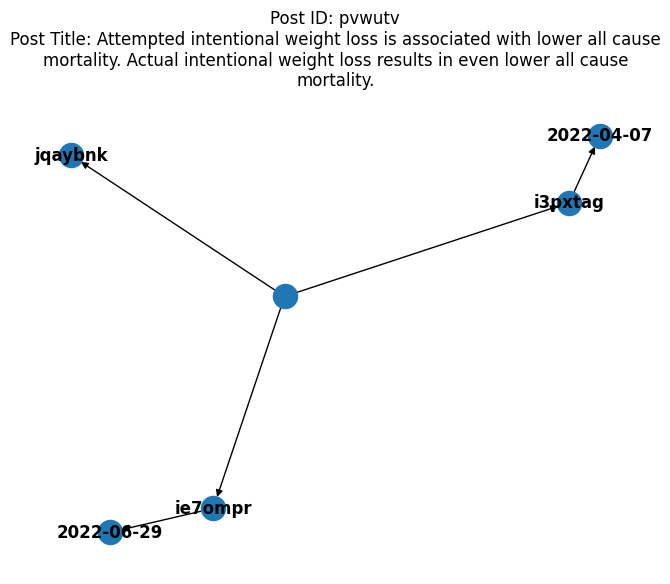

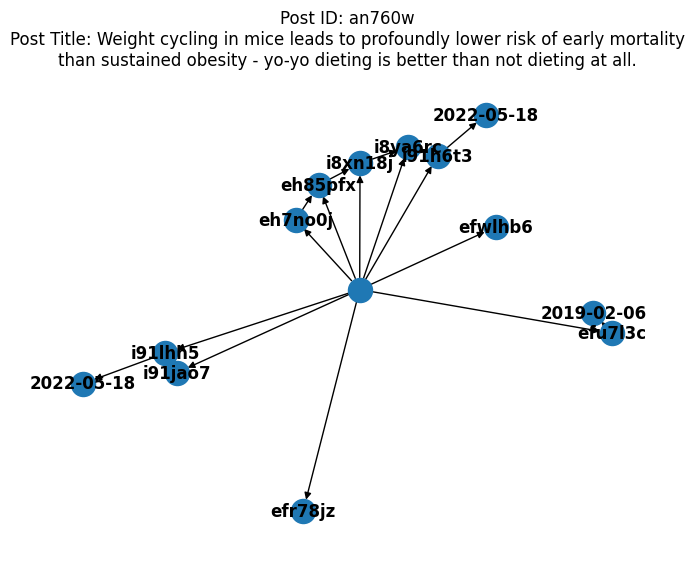

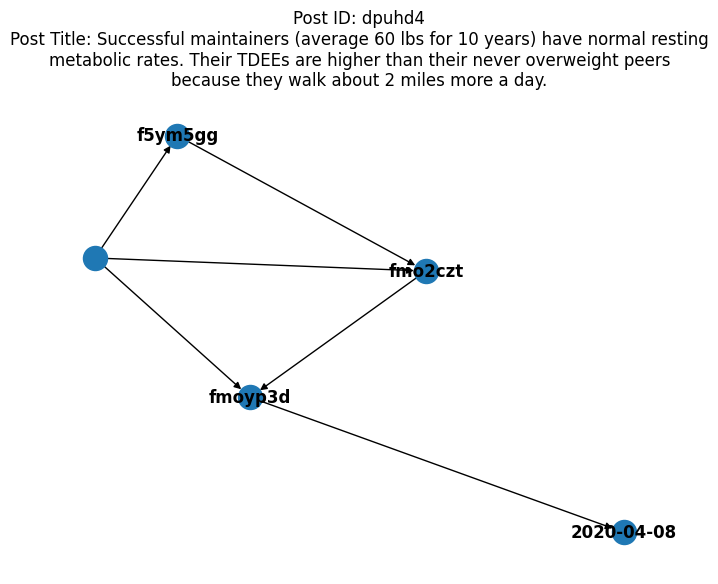

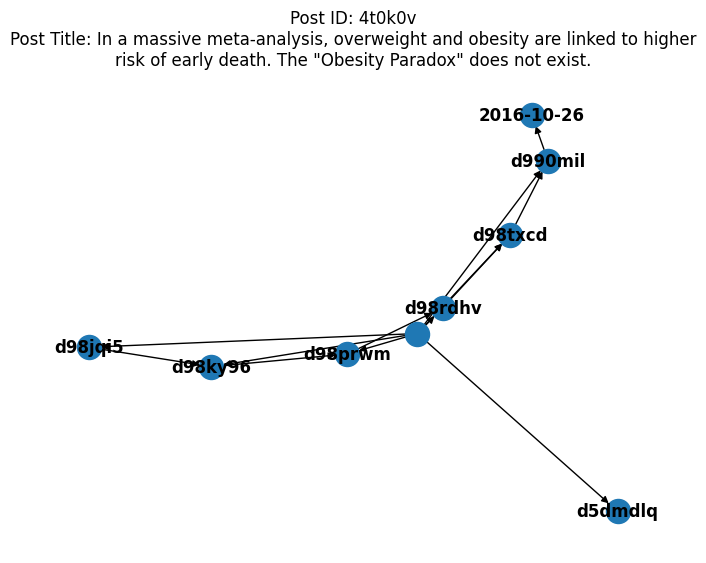

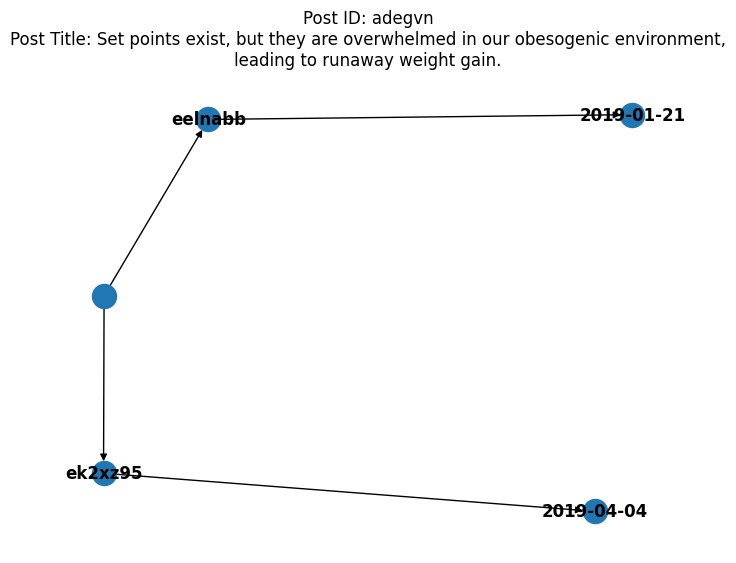

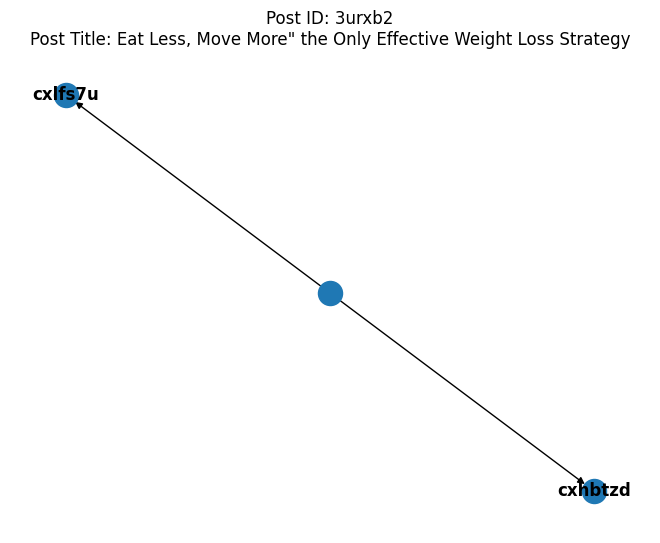

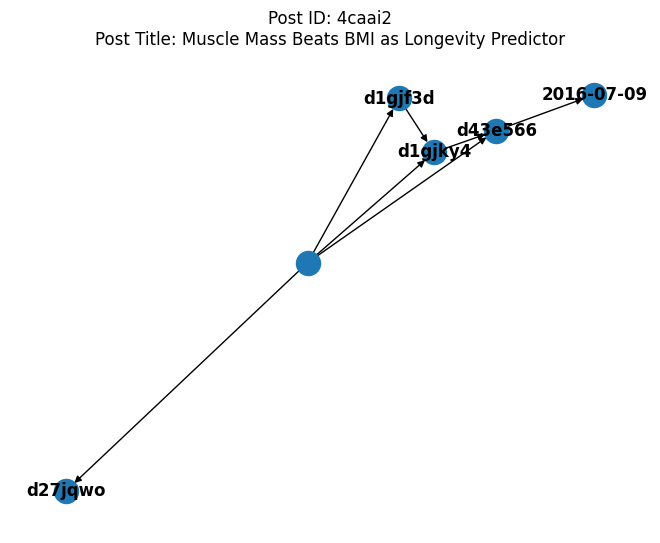

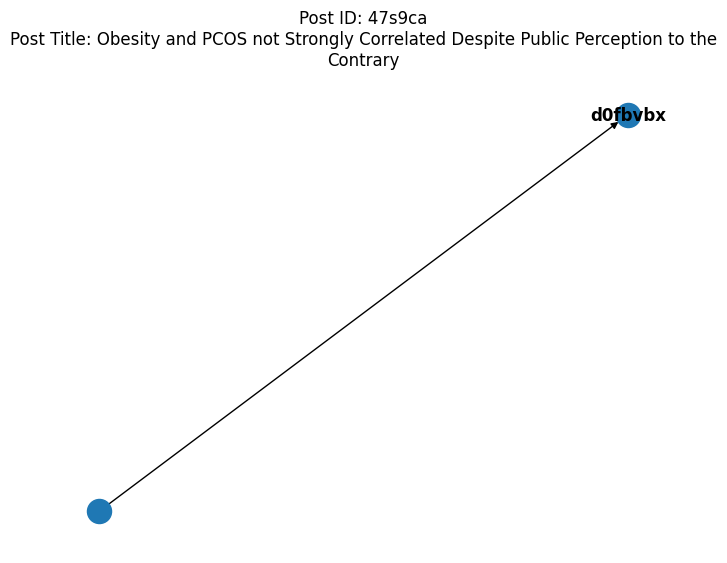

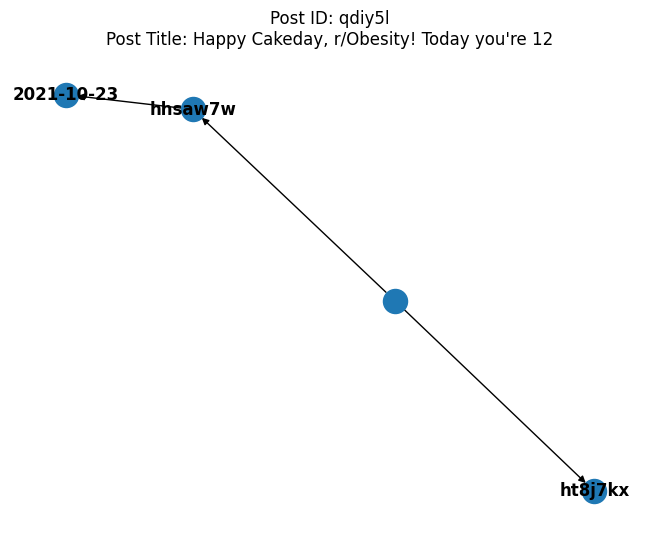

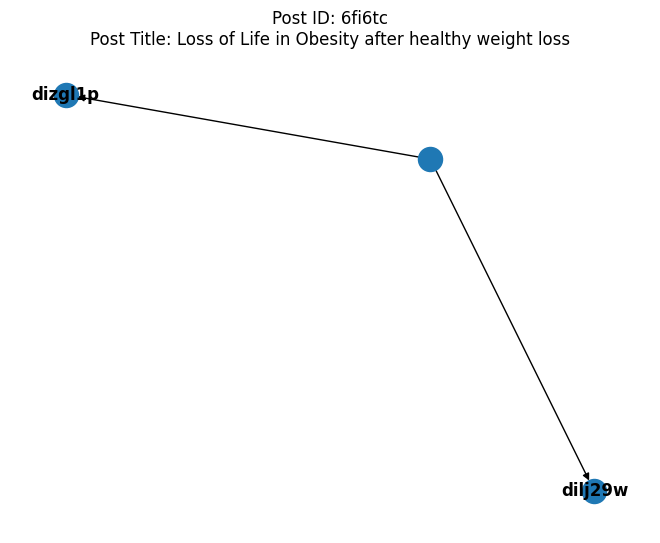

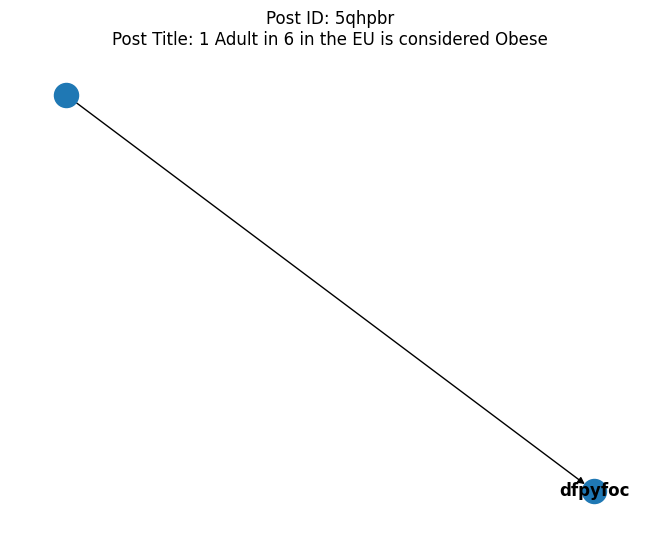

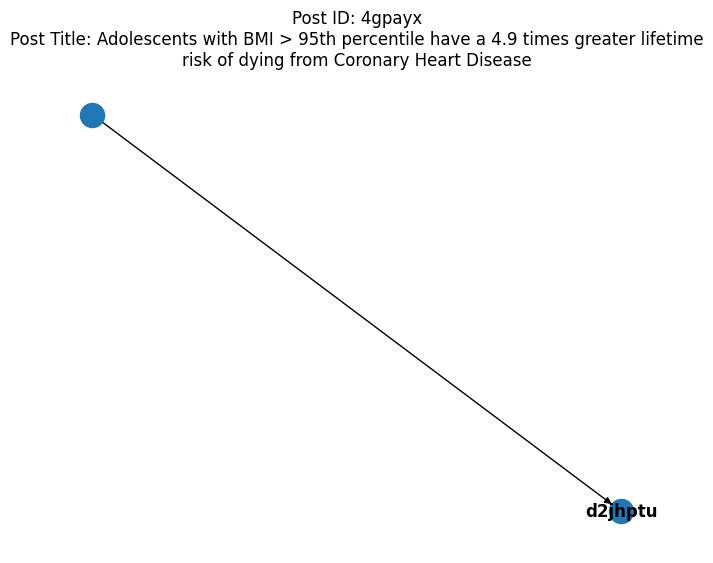

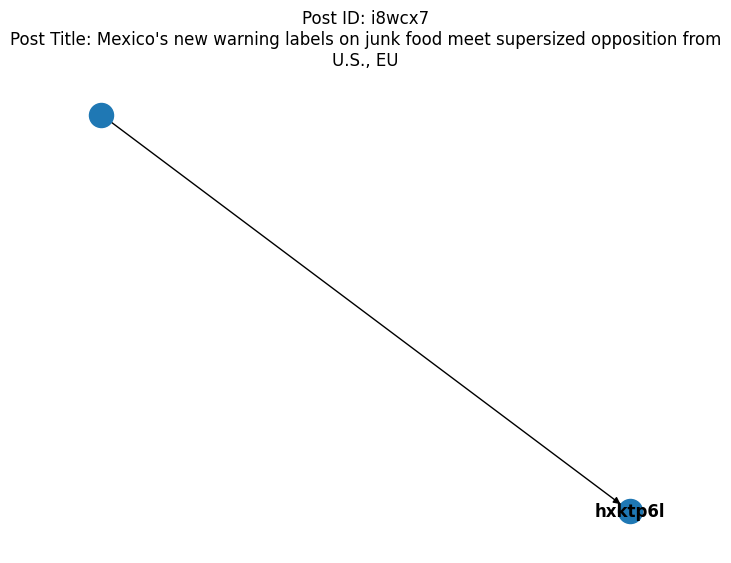

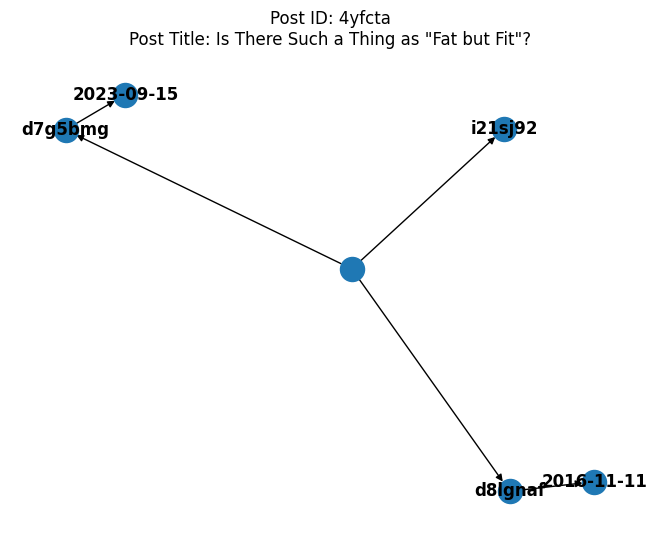

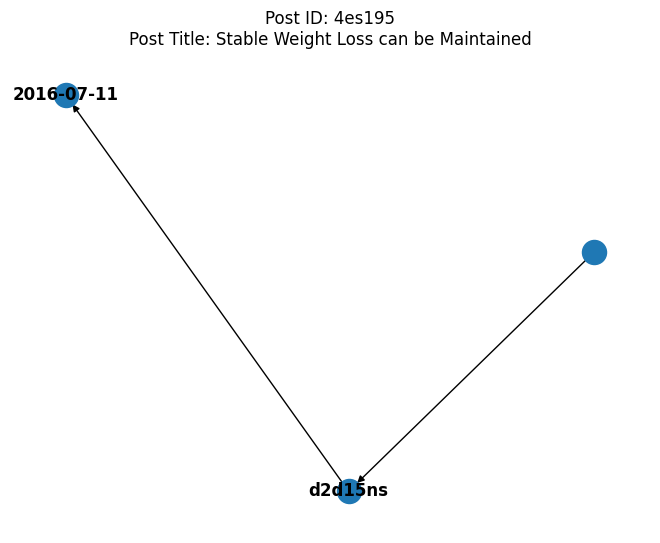

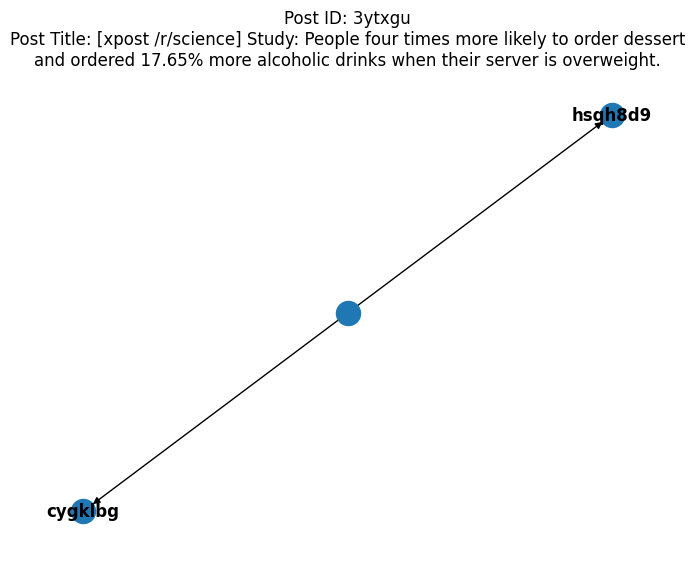

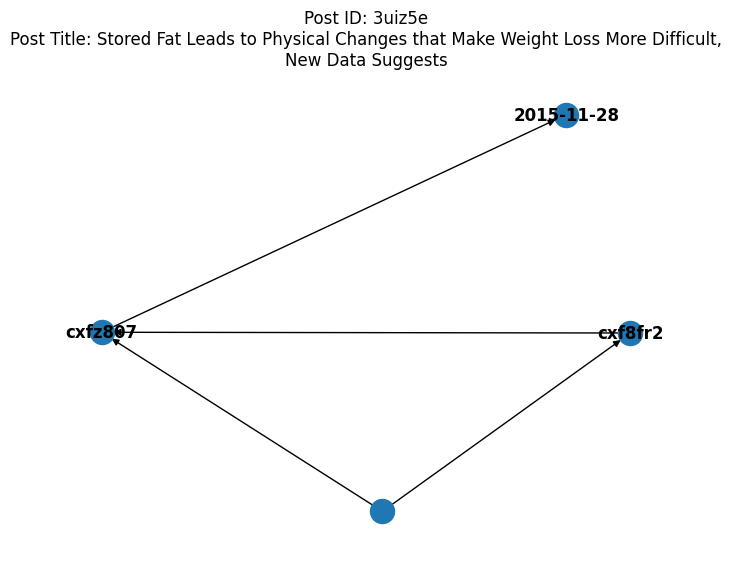

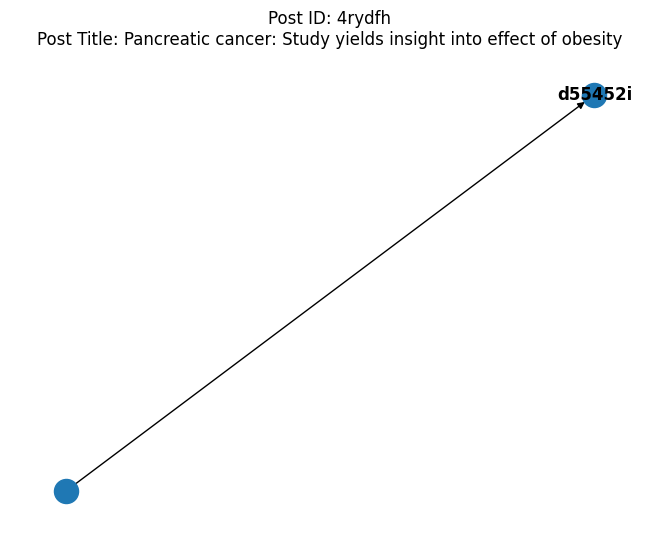

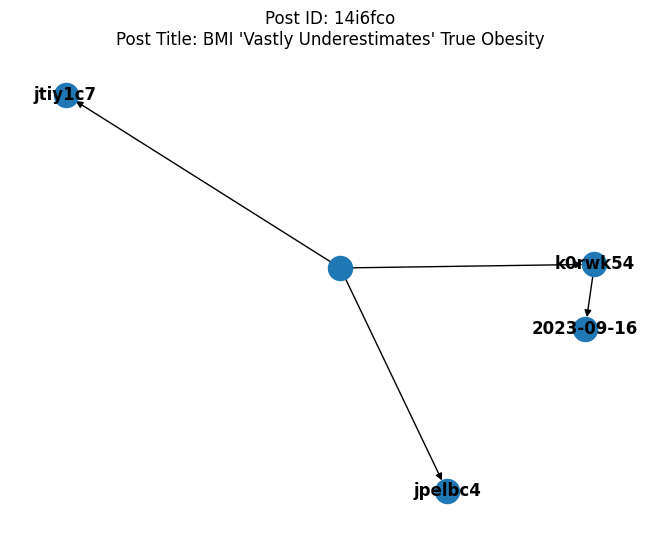

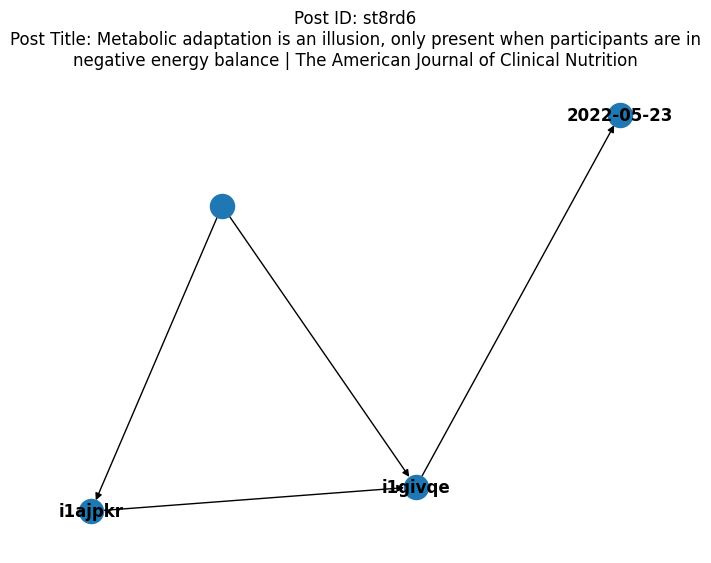

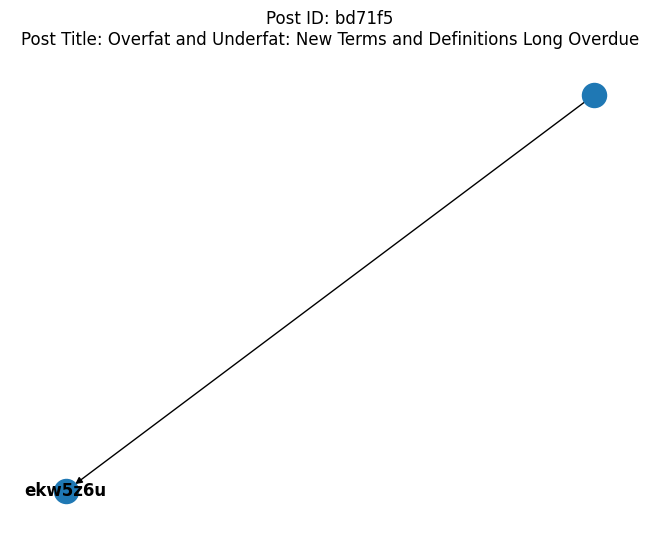

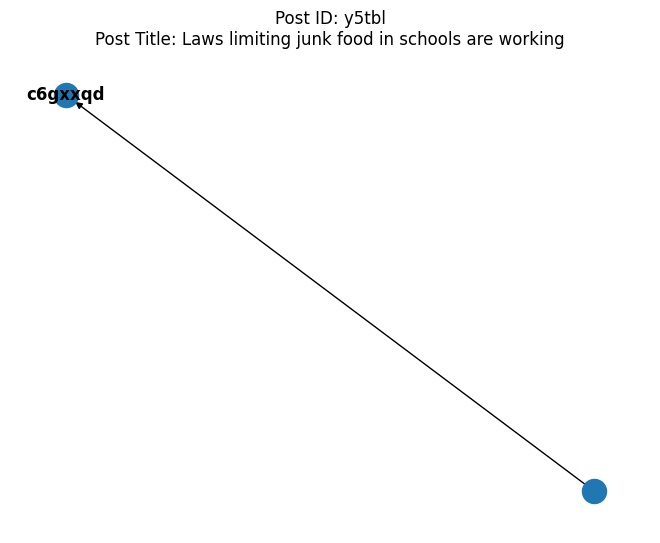

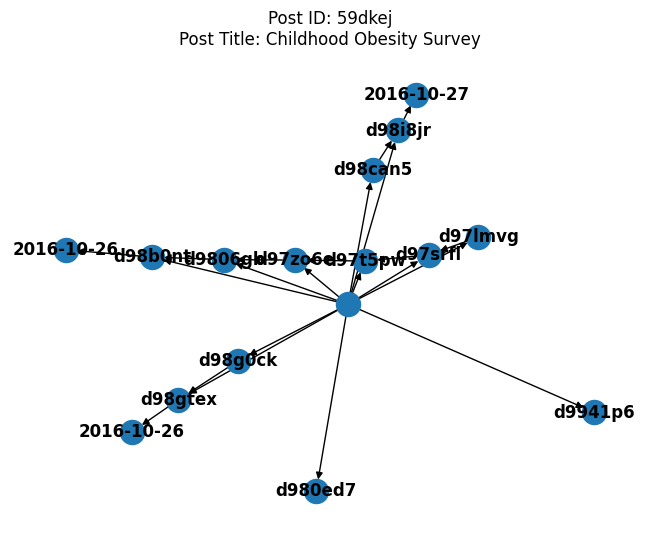

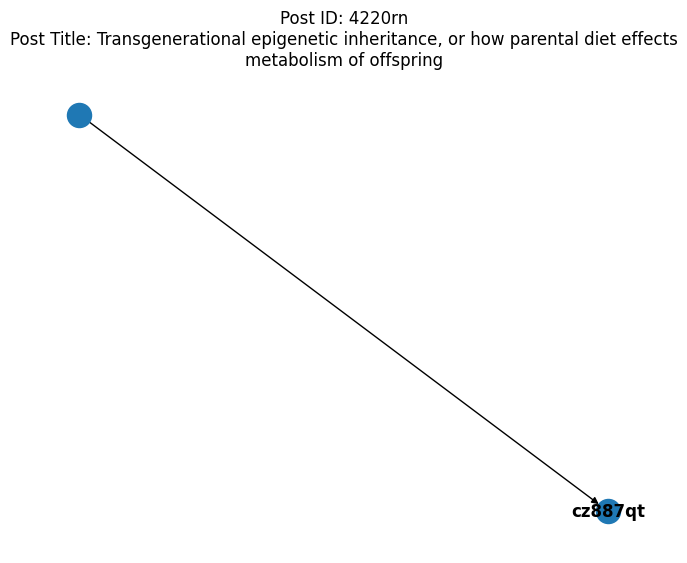

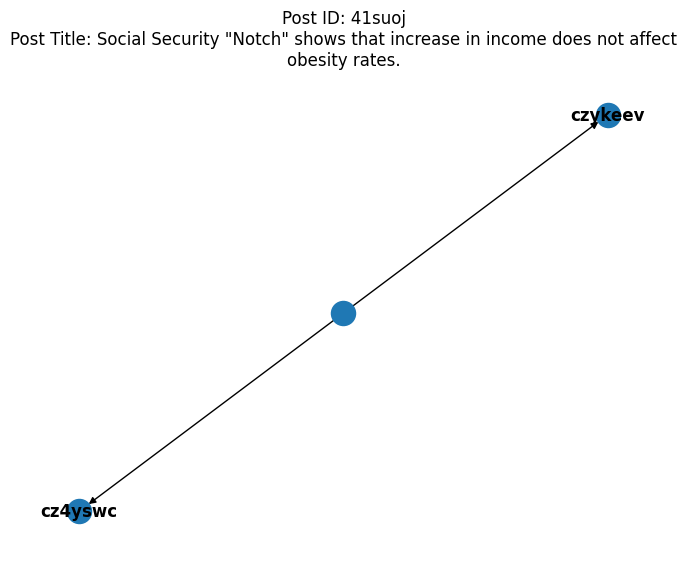

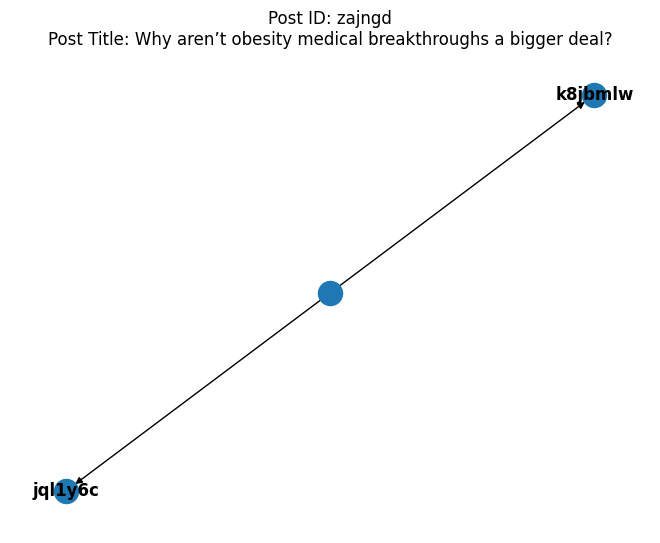

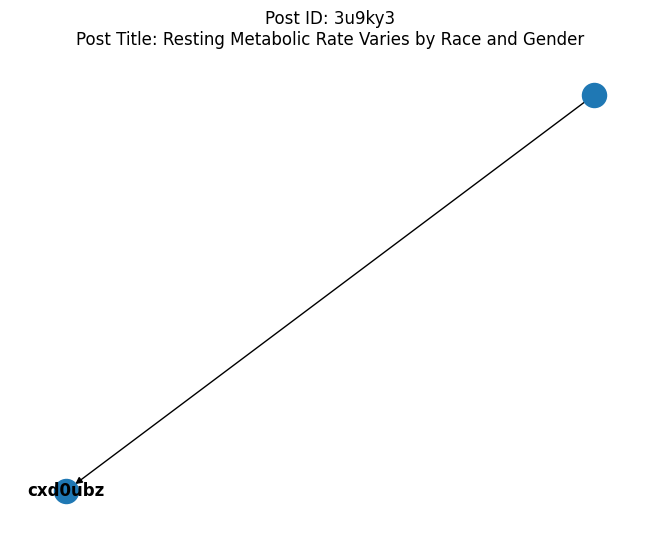

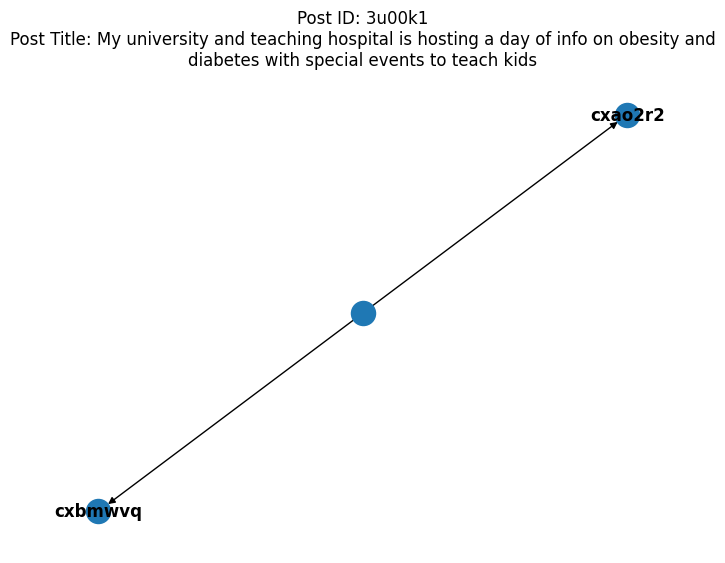

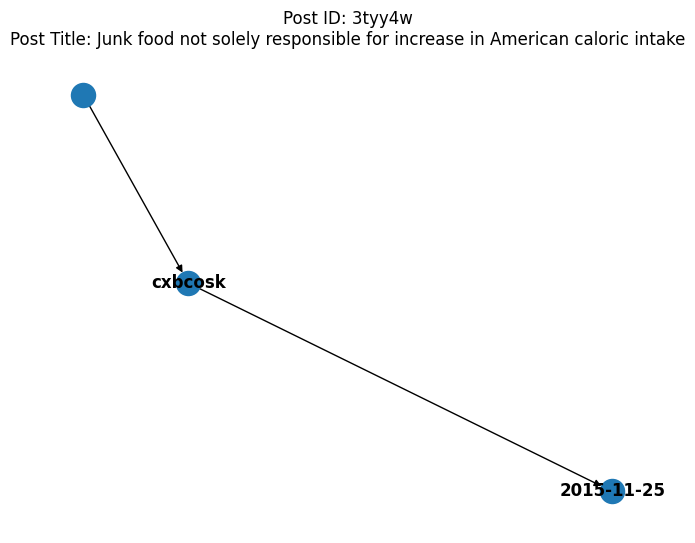

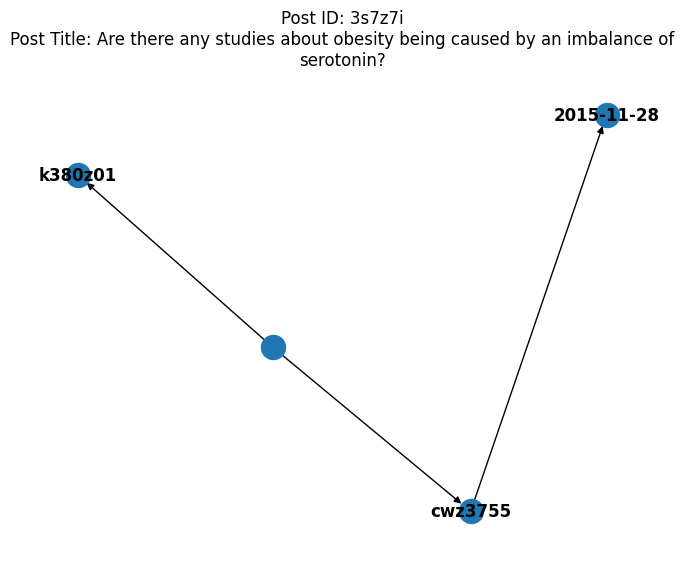

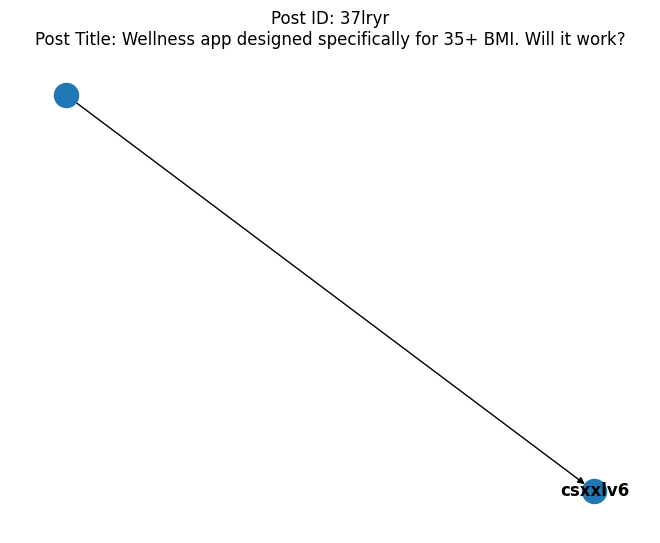

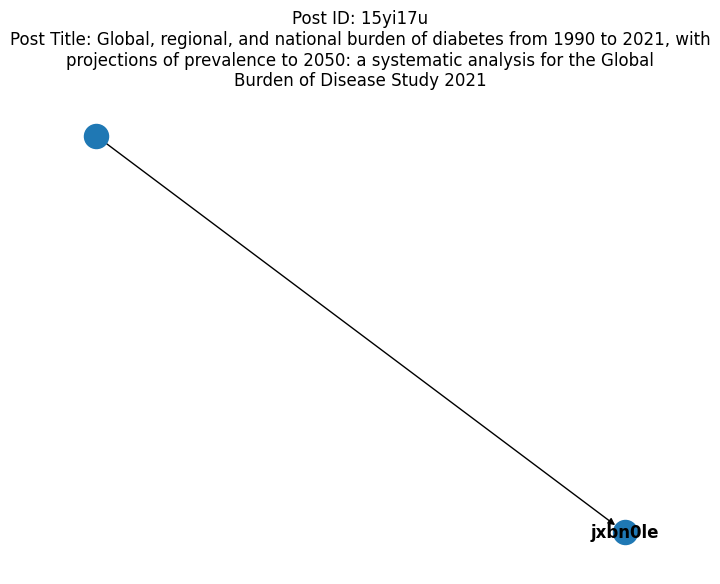

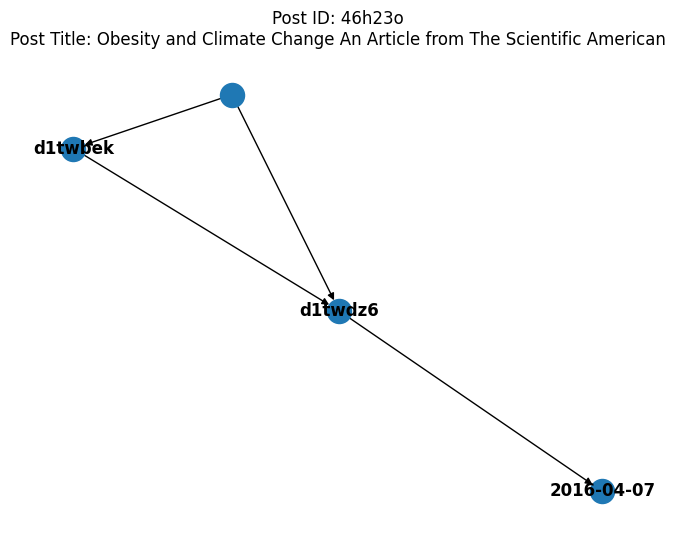

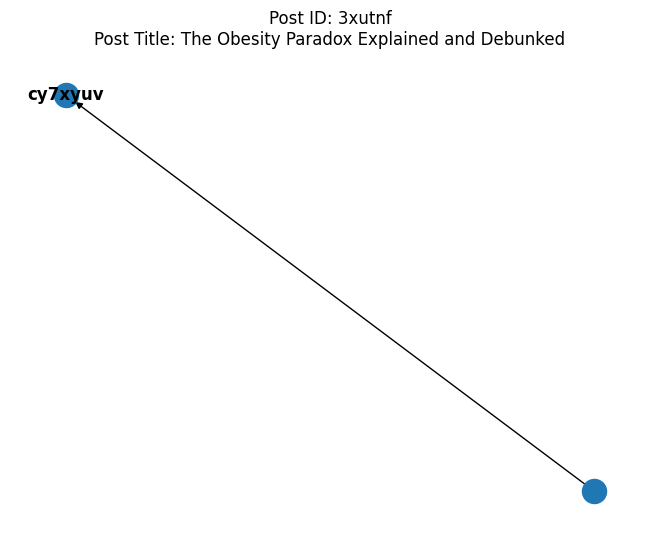

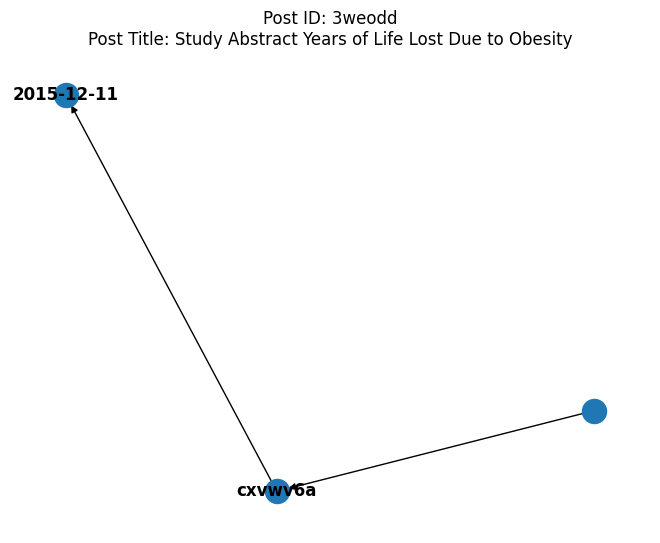

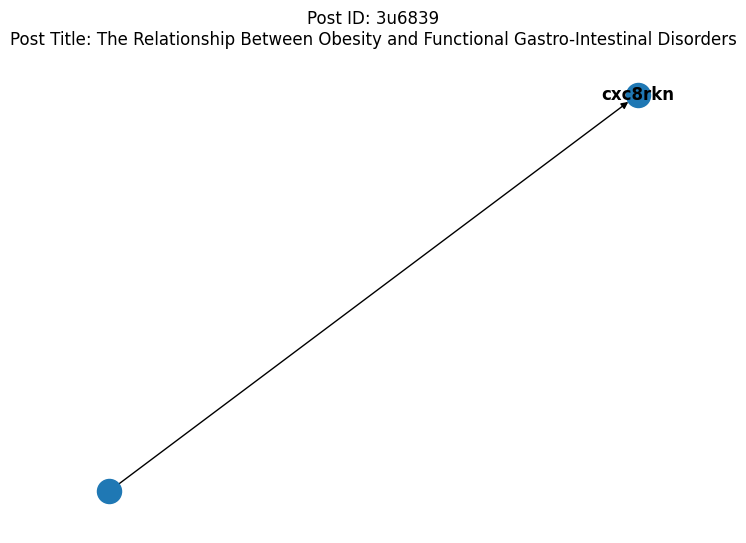

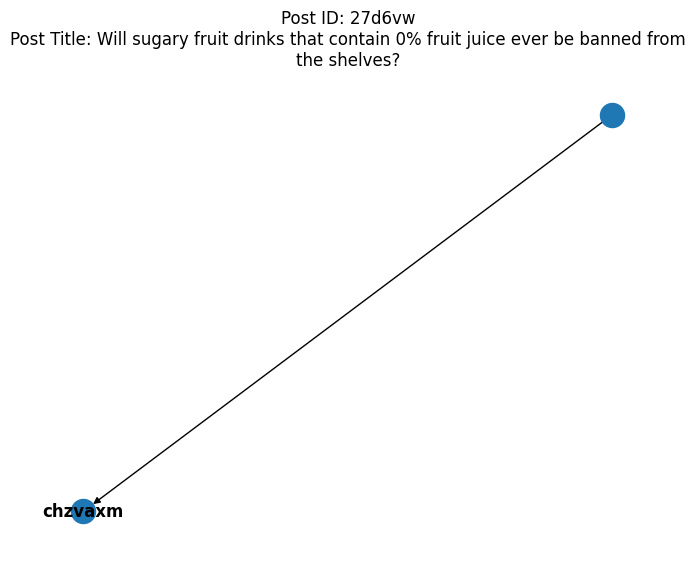

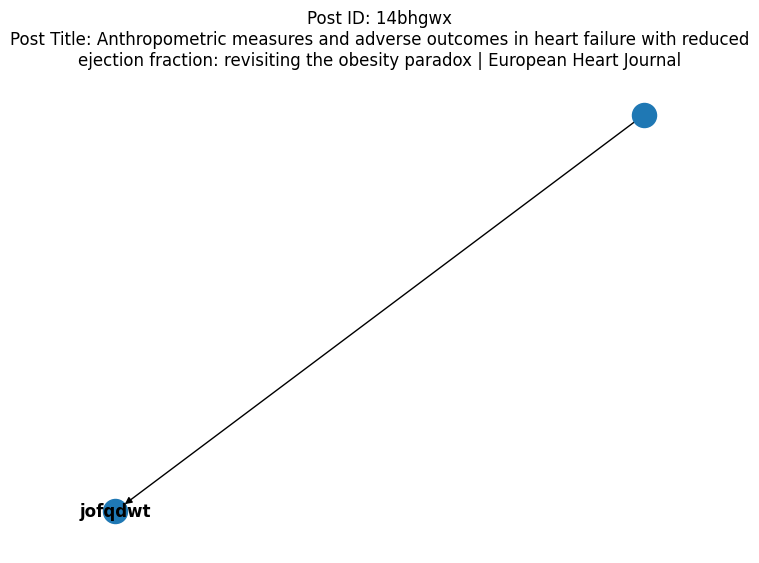

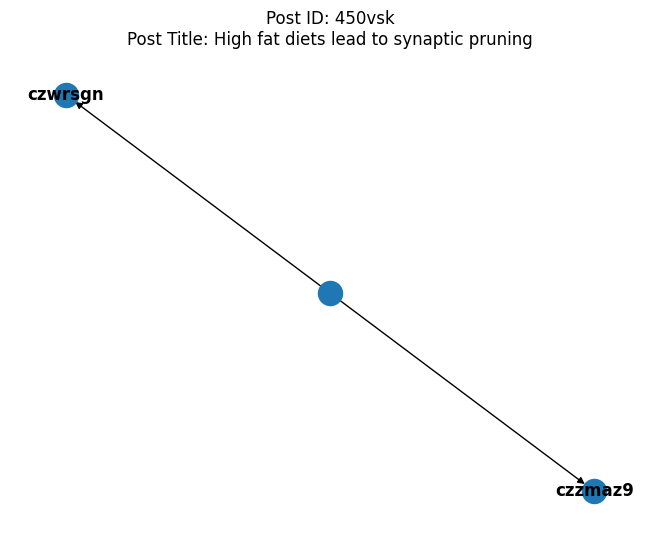

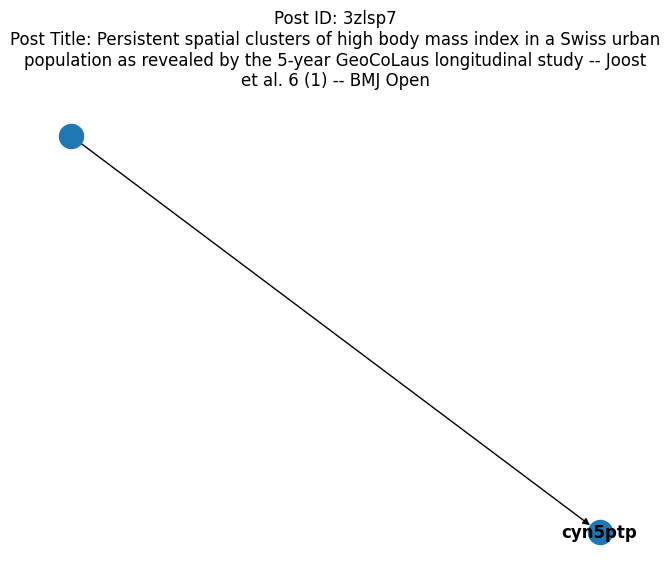

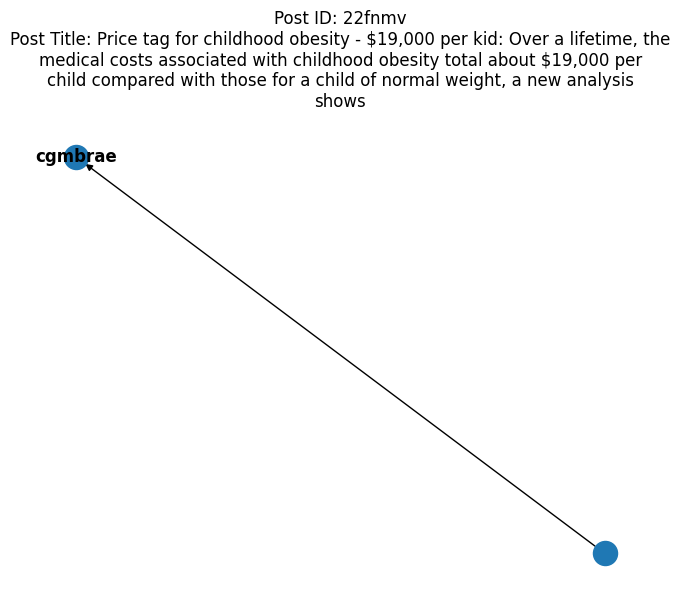

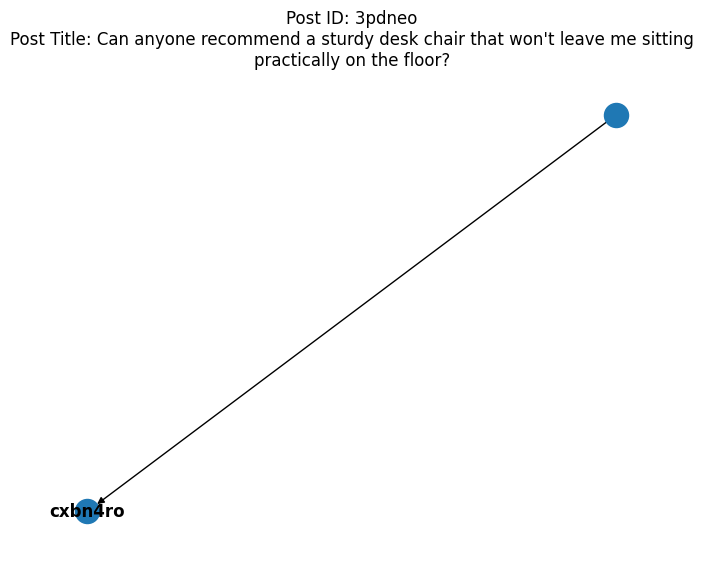

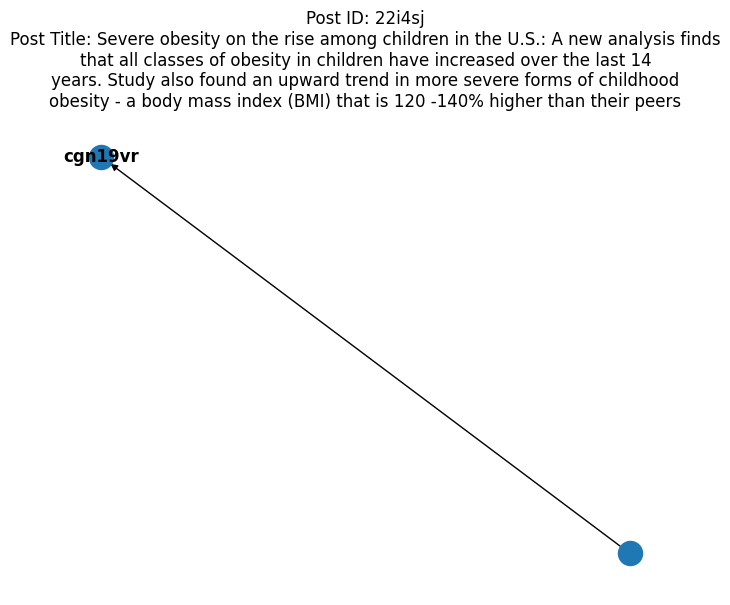

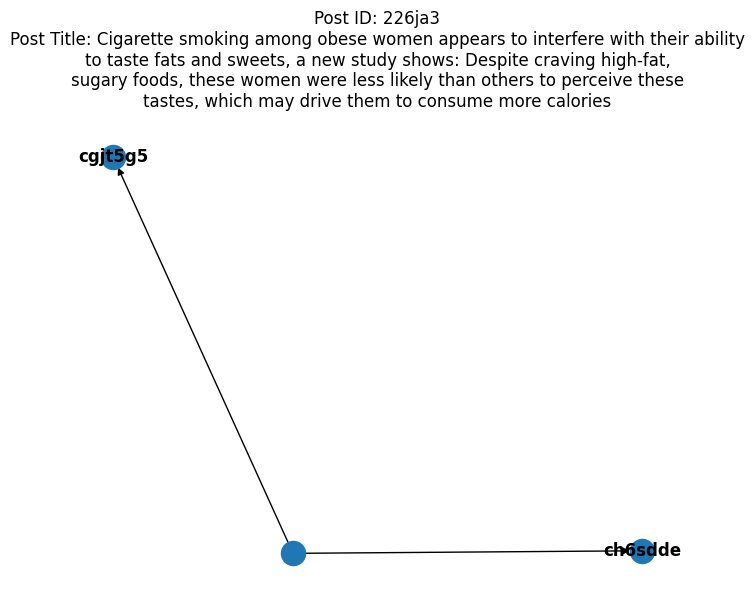

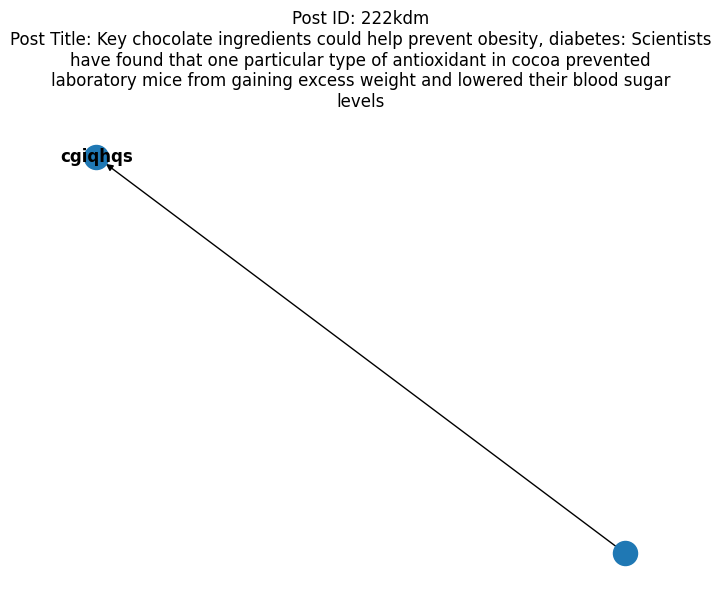

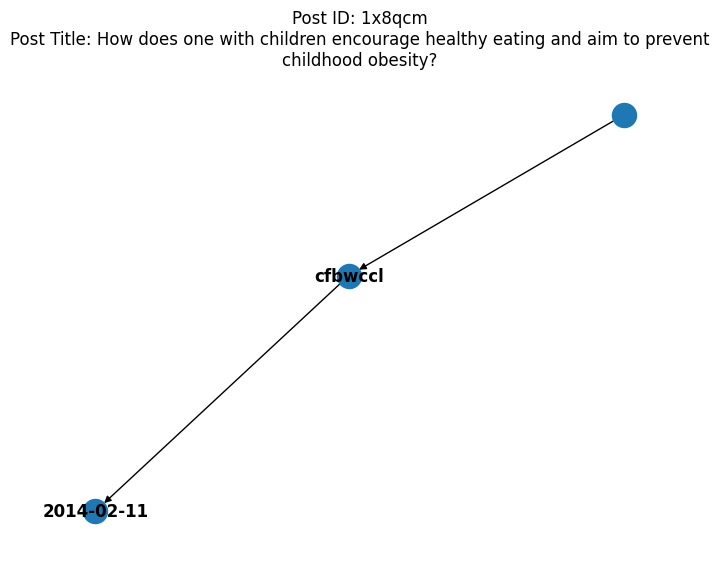

In [13]:
for p in posts_with_comments:
    plotGraph(p)

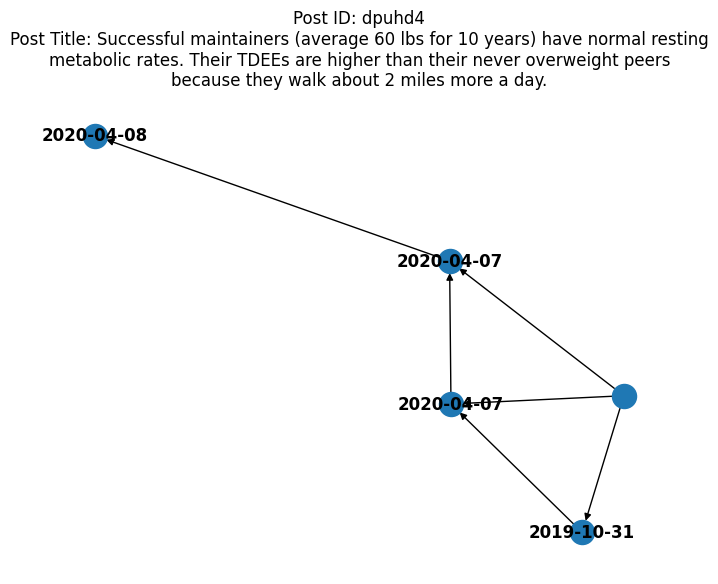

In [9]:
plotGraph(posts_with_comments[2])

In [226]:
# node_colors = ['hotpink' if isinstance(node, str) else 'skyblue' for node in reddit_tree.nodes]